Now the big problem is: how to distinguish candy from background galaxies?

1. Calculate physical radius and stellar mass based on the associated host's redshift
2. Try to use Sersic $n$, $\mu_e / \mu_0$, etc.

In [51]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os, sys
import dill, pickle
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row
from astropy.convolution import convolve, Gaussian2DKernel

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [94]:
lsbg_cat = Table.read('./Cutout/NSA/nsa_cutout_cat_1103.fits')
meas_cat = Table.read('./Catalog/nsa_vanilla_sample_measurement_1103_success.fits')

In [95]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

#mask &= (meas_cat['SB_0'][:, 2] > 21)
mask &= (meas_cat['SB_eff_ellip'][:, 2] > 22)
mask &= (meas_cat['C'] < 3.5)
mask &= (meas_cat['rhalf_ellip'] > 2 / 0.168)

In [96]:
lsbg_cat = lsbg_cat[mask]
meas_cat = meas_cat[mask]

In [98]:
with open('./Catalog/hosts_nsa_z001_002_20hosts.pkl', 'rb') as f:
    host_cat = pickle.load(f)

In [99]:
host_z = np.zeros(len(meas_cat))

In [100]:
for i, lsbg in enumerate(meas_cat):
    ind = int(lsbg['ID'])
    _match = [host['Z'] for host in host_cat if ind in host['1vir_lsbg_idx']]
    if len(_match) > 1:
        print(f'More than one is matched for {i}:', _match)
    host_z[i] = _match[0]

More than one is matched for 9: [0.017888216, 0.017068766]
More than one is matched for 14: [0.017888216, 0.017068766]
More than one is matched for 19: [0.017888216, 0.01770225, 0.017068766]
More than one is matched for 38: [0.017888216, 0.017068766]
More than one is matched for 50: [0.017888216, 0.01770225, 0.017068766]
More than one is matched for 62: [0.017888216, 0.017068766]
More than one is matched for 64: [0.017888216, 0.01770225, 0.017068766]
More than one is matched for 71: [0.017888216, 0.017068766]
More than one is matched for 74: [0.017888216, 0.017068766]
More than one is matched for 86: [0.01819565, 0.017543709]
More than one is matched for 94: [0.017888216, 0.017068766]
More than one is matched for 99: [0.017888216, 0.017068766]
More than one is matched for 100: [0.017888216, 0.017068766]
More than one is matched for 112: [0.017888216, 0.017068766]
More than one is matched for 124: [0.017888216, 0.017068766]
More than one is matched for 129: [0.017888216, 0.017068766]
Mo

In [101]:
meas_cat.add_column(Column(data=host_z, name='host_z'))

In [102]:
from astropy.cosmology import Planck15
cosmos = Planck15

In [103]:
ang_diam_dist = cosmos.angular_diameter_distance(meas_cat['host_z']).value # not consider peculiar motion
rhalf_phys = meas_cat['rhalf_circ'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
meas_cat['rhalf_circ_phys'] = rhalf_phys

In [104]:
#### Calcualte a mass. First calculate the absolute magnitude: $M = m - 5 * np.log10(D (Mpc) * 1e6)$

In [105]:
meas_cat['abs_mag'] = meas_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri

In [111]:
meas_cat['abs_mag'][1], meas_cat['rhalf_circ_phys'][1]

(array([-16.24708551, -16.55904954, -16.7825107 , -16.85953897]),
 1.15106689910982)

In [123]:
BV = 0.62 * (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 1]) + 0.15
V = meas_cat['mag'][:, 0] - 0.52 * (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 1]) - 0.03
V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
log_ML_V = 1.493 * BV - 0.681

In [129]:
M = (4.83 - V_abs) / (2.5) + log_ML_V

In [142]:
meas_cat[meas_cat['sersic_n'] > 2]['ID']

4301.0
13203.0
18167.0
23059.0
48914.0
70553.0
76316.0
89929.0


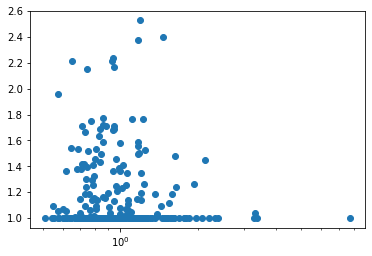

In [141]:
plt.scatter(meas_cat['rhalf_circ_phys'], meas_cat['sersic_n'])
plt.xscale('log')

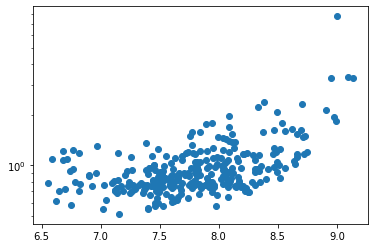

In [133]:
plt.scatter(M, meas_cat['rhalf_circ_phys'])

plt.yscale('log')

In [134]:
meas_cat['ID'][M < 7]

2876.0
5807.0
9016.0
9401.0
13635.0
14376.0
18167.0
26176.0
45917.0
46387.0
46552.0


(array([14., 10., 24., 52., 64., 56., 37., 18., 12.,  7.]),
 array([6.55693398, 6.81461167, 7.07228937, 7.32996706, 7.58764476,
        7.84532245, 8.10300015, 8.36067784, 8.61835554, 8.87603323,
        9.13371093]),
 <BarContainer object of 10 artists>)

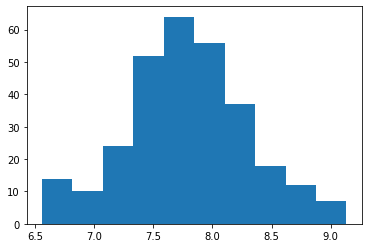

In [130]:
plt.hist(M)

In [119]:
10**log_ML_V

0.5346531290685997
0.5620811864291252
0.5895917505276846
0.6144491100909852
0.6621525131050504
0.5930847425117246
0.7650845552685569
0.5478859565173971
0.5239100025190536
0.6684625396762895
0.5886385584143478


In [109]:
meas_cat[1]

ID,flux [4],mag [4],SB_0 [4],SB_eff_circ [4],SB_eff_ellip [4],xc_cen,yc_cen,xc_sym,yc_sym,ell_cen,ell_sym,PA_cen,PA_sym,rhalf_circ,rhalf_ellip,r20,r50,r80,Gini,M20,"F(G,M20)","S(G,M20)",C,A,S,sersic_n,sersic_rhalf,sersic_ell,sersic_PA,sersic_xc,sersic_yc,sersic_amp,flag,flag_sersic,host_z,rhalf_circ_phys,abs_mag [4]
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
441.0,3034.659423828125 .. 5334.4677734375,18.29472541809082 .. 17.68227195739746,21.506235122680664 .. 20.893781661987305,23.276185989379883 .. 22.663732528686523,23.246139526367188 .. 22.633686065673828,49.72450941280484,50.574492933053385,49.17513591496513,50.551628765984944,0.11395596438140965,0.11329115767549691,1.5439355864301079,1.5435561358106524,17.45237914231233,18.44279407151893,8.772267914957368,17.446047530766567,27.96581938593165,0.4236656424374385,-1.7117191613699871,-0.6766336911052786,-0.14549997741736415,2.5175783071614783,0.22806991297890833,0.035328362294608937,1.0,18.44279407151893,0.11329115767549691,1.5435561358106524,49.17513591496513,50.551628765984944,0.898955830234954,1.0,1.0,0.01872136816382408,1.15106689910982,-16.247085509009125 .. -16.859538969702484


### Analysis

In [14]:
import kuaizi
kuaizi.set_matplotlib(style='nature', usetex=False)

In [15]:
meas_cat = Table.read('./Catalog/nsa_vanilla_sample_measurement_1103_success.fits')

In [87]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

In [88]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [89]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 137
Gal: 208
Junk: 156


In [90]:
#lsbg_cat[candy & mask]

In [91]:
0.7 * 1.2 - 0.4

0.43999999999999995

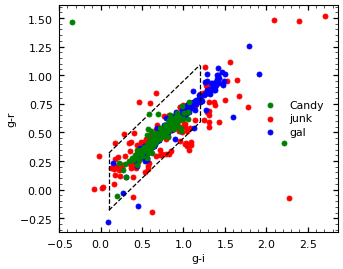

In [92]:
plt.scatter((g_mag - i_mag)[candy], (g_mag - r_mag)[candy], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk], (g_mag - r_mag)[junk], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal], (g_mag - r_mag)[gal], color='b', label='gal')

color_bound = [0.1, 1.2]
half_width = 0.25
plt.vlines(color_bound[0], 0.7 * color_bound[0] - half_width, 
           0.7 * color_bound[0] + half_width, color='k', ls='--')
plt.vlines(color_bound[1], 0.7 * color_bound[1] - half_width, 
           0.7 * color_bound[1] + half_width, color='k', ls='--')

x = np.linspace(color_bound[0], color_bound[1], 100)
plt.plot(x, 0.7 * x - half_width, color='k', ls='--')
plt.plot(x, 0.7 * x + half_width, color='k', ls='--')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

#plt.xlim(-0.5, 2.2)
#plt.ylim(-0.5, 2.2)

Text(0, 0.5, 'SB_0_i')

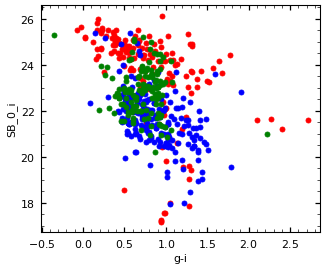

In [93]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_0'][:, 2][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_0'][:, 2][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_0'][:, 2][gal], color='b')

plt.xlabel('g-i')
plt.ylabel('SB_0_i')

Text(0, 0.5, 'SB_eff_i')

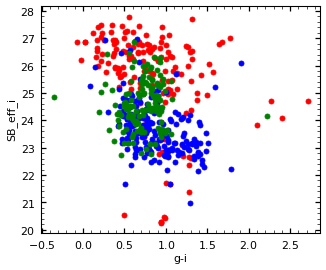

In [94]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_eff_ellip'][:, 1][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_eff_ellip'][:, 1][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_eff_ellip'][:, 1][gal], color='b')

plt.xlabel('g-i')
plt.ylabel('SB_eff_i')

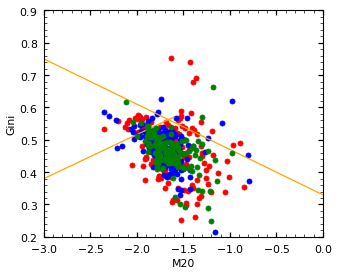

In [95]:
plt.scatter(meas_cat['M20'][candy], meas_cat['Gini'][candy], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk], meas_cat['Gini'][junk], color='r')
plt.scatter(meas_cat['M20'][gal], meas_cat['Gini'][gal], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'A')

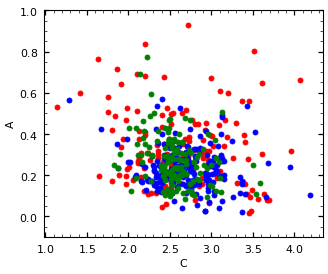

In [96]:
plt.scatter(meas_cat['C'][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['A'][gal], color='b')

plt.ylim(-0.1, 1)
plt.xlabel('C')
plt.ylabel('A')

Text(0, 0.5, 'S')

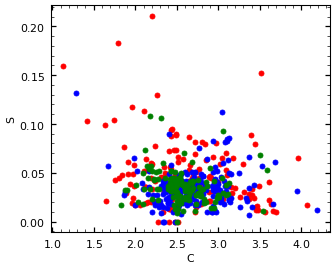

In [97]:
plt.scatter(meas_cat['C'][candy], meas_cat['S'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['S'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['S'][gal], color='b')

#plt.ylim(-0.1, 1)
plt.xlabel('C')
plt.ylabel('S')

Text(0, 0.5, 'r50')

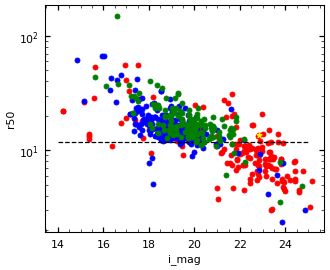

In [98]:
plt.scatter(i_mag[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(i_mag[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(i_mag[gal], meas_cat['rhalf_ellip'][gal], color='b')
plt.scatter(i_mag[223], meas_cat['rhalf_ellip'][223], color='yellow', marker='*', s=50, label='gal', zorder=10)


#plt.ylim(0, 1)
plt.hlines(2 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

In [99]:
np.where(lsbg_cat['viz-id'] == 58474)

(array([327]),)

(0.0, 30.0)

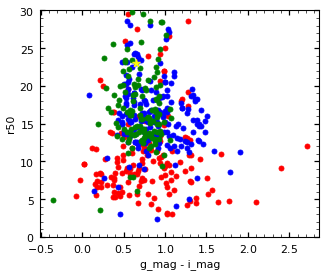

In [100]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['rhalf_ellip'][gal], color='b')
plt.scatter((g_mag - i_mag)[327], meas_cat['rhalf_ellip'][327], color='yellow', marker='*', s=100, label='gal', zorder=10)

#plt.ylim(0, 1)
#plt.yscale('log')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')

plt.ylim(0, 30)

In [109]:
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

#mask &= (meas_cat['SB_0'][:, 2] > 21)
mask &= (meas_cat['SB_eff_ellip'][:, 2] > 22)

mask &= (meas_cat['C'] < 3.5)

mask &= (meas_cat['rhalf_ellip'] > 2 / 0.168)
print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 123
Gal: 150
Junk: 21


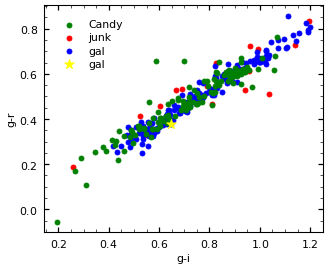

In [102]:
plt.scatter((g_mag - i_mag)[candy & mask], (g_mag - r_mag)[candy & mask], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk & mask], (g_mag - r_mag)[junk & mask], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal & mask], (g_mag - r_mag)[gal & mask], color='b', label='gal')

plt.scatter((g_mag - i_mag)[327], (g_mag - r_mag)[327], color='yellow', marker='*', s=150, label='gal', zorder=10)

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

#plt.xlim(-0.5, 2.2)
#plt.ylim(-0.5, 2.2)

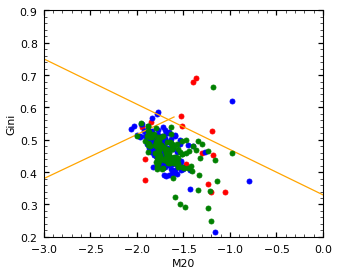

In [103]:
plt.scatter(meas_cat['M20'][candy & mask], meas_cat['Gini'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk & mask], meas_cat['Gini'][junk & mask], color='r')
plt.scatter(meas_cat['M20'][gal & mask], meas_cat['Gini'][gal & mask], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'r50')

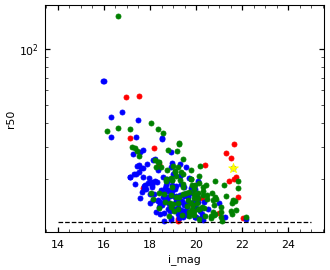

In [104]:
plt.scatter(i_mag[candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(i_mag[junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(i_mag[gal & mask], meas_cat['rhalf_ellip'][gal & mask], color='b')
plt.scatter(i_mag[327], meas_cat['rhalf_ellip'][327], color='yellow', marker='*', s=150, label='gal', zorder=10)


#plt.ylim(0, 1)
plt.hlines(2 / 0.168, 14, 25, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50')

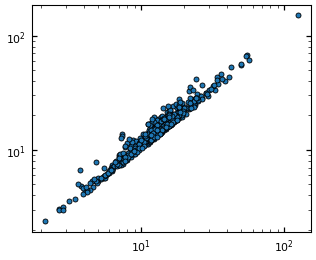

In [30]:
plt.scatter(meas_cat['r50'], meas_cat['sersic_rhalf'])
plt.xscale('log')
plt.yscale('log')

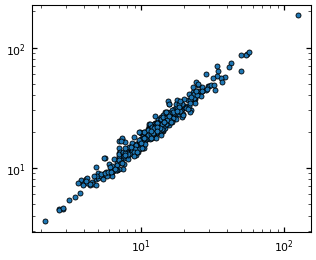

In [31]:
plt.scatter(meas_cat['r50'], meas_cat['r80'])
plt.xscale('log')
plt.yscale('log')

In [32]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 178
Gal: 167
Junk: 156


Text(0, 0.5, 'r50')

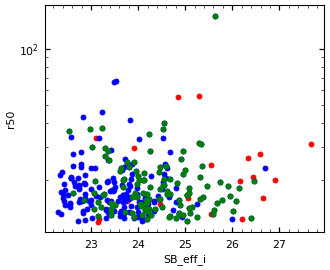

In [106]:
plt.scatter(meas_cat['SB_eff_circ'][:, 2][candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_circ'][:, 2][junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(meas_cat['SB_eff_circ'][:, 2][~junk & mask], meas_cat['rhalf_ellip'][~junk & mask], color='b')

#plt.ylim(0, 1)
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50')

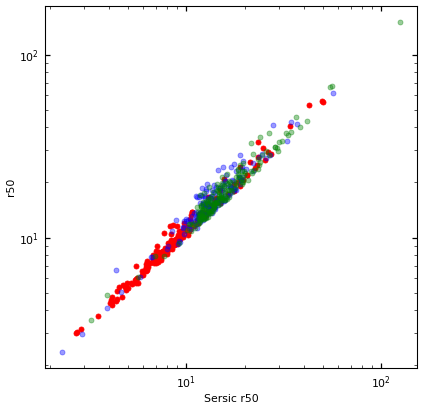

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(meas_cat['rhalf_circ'][candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10, alpha=.4)
plt.scatter(meas_cat['rhalf_circ'][junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(meas_cat['rhalf_circ'][gal], meas_cat['rhalf_ellip'][gal], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(-5, 100)
#plt.ylim(-5, 100)

plt.xlabel('Sersic r50')
plt.ylabel('r50')
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'r50 / r20')

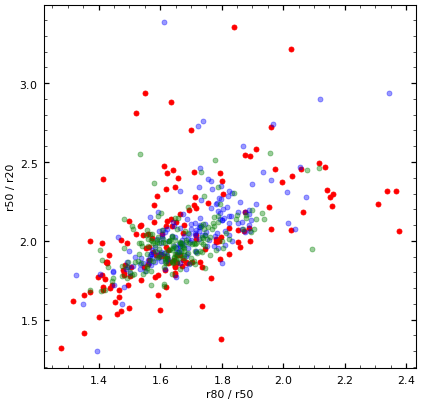

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(meas_cat['r80'][candy] / meas_cat['r50'][candy], 
            meas_cat['r50'][candy] / meas_cat['r20'][candy], color='g', zorder=10, alpha=.4)

plt.scatter(meas_cat['r80'][junk] / meas_cat['r50'][junk], 
            meas_cat['r50'][junk] / meas_cat['r20'][junk], color='r')

plt.scatter(meas_cat['r80'][gal] / meas_cat['r50'][gal], 
            meas_cat['r50'][gal] / meas_cat['r20'][gal], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(-5, 100)
#plt.ylim(-5, 100)

plt.xlabel('r80 / r50')
plt.ylabel('r50 / r20')

In [79]:
lsbg_cat[mask].write('./Catalog/nsa_20hosts_sample_211103_visual_inspect.fits', overwrite=True)

In [110]:
1.5 / (50 * 1000) * 206265

6.18795